In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = '/content/drive/MyDrive/Hotel System/'
df = pd.read_csv(path + 'hotel_train.csv')
df_test = pd.read_csv(path + 'hotel_test.csv')

print(f'Train shape: {df.shape}')
print(f'Test shape: {df_test.shape}')

Train shape: (65229, 25)
Test shape: (32412, 25)


In [3]:
print(df.head())

   id  is_canceled  ...  total_of_special_requests  total_nights
0   0            0  ...                          0             1
1   1            0  ...                          1             2
2   2            0  ...                          0             2
3   3            0  ...                          1             2
4   4            1  ...                          1             3

[5 rows x 25 columns]


Somebody has 10 babies with him/her. And somebody cancelled 26 reservations in the past.

In [8]:
df.describe()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,43544.069172,0.368609,96.337917,2015.719021,31.339772,15.847813,0.825185,2.224793,1.836576,0.074890,0.007236,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978
std,25614.858971,0.482431,96.127545,0.449481,13.464024,8.748182,0.853477,1.354992,0.480245,0.334243,0.098790,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19108.000000,0.000000,17.000000,2015.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,40554.000000,0.000000,64.000000,2016.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,67414.000000,1.000000,151.000000,2016.000000,42.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,84121.000000,1.000000,374.000000,2016.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000


Seems like perfect data for me

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

Lets clean guests with more than 5 babys. Otherwise it will be an Anomaly.

In [12]:
df[df['babies'] > 5]

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
22995,30935,0,37.0,2016,January,3,12,0,2,2.0,0.0,10.0,BB,PRT,TA/TO,0,0,0,D,1,0,Transient,0,1,2
41528,59925,0,11.0,2015,October,42,11,2,1,1.0,0.0,9.0,BB,GBR,Corporate,0,0,0,A,1,0,Transient-Party,0,0,3


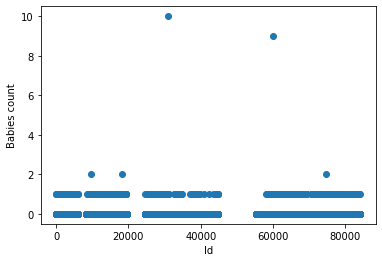

In [17]:
plt.scatter(df['id'], df['babies'])
plt.xlabel('Id')
plt.ylabel('Babies count')
plt.show()

In [20]:
df = df.loc[df['babies'] < 3, :]

Let's observe count of previous cancellations

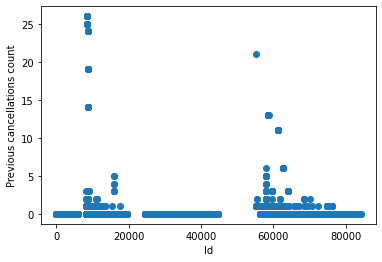

In [21]:
plt.scatter(df['id'], df['previous_cancellations'])
plt.xlabel('Id')
plt.ylabel('Previous cancellations count')
plt.show()